In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import wilcoxon

**Data loading and preprocessing**

In [ ]:
df = pd.read_csv('HR_data.csv')

print(df.head())
df.isna().sum()
print(df['Frustrated'].unique())

   Unnamed: 0    HR_Mean  HR_Median    HR_std  HR_Min  HR_Max     HR_AUC  \
0           0  77.965186      78.00  3.345290   73.23   83.37  22924.945   
1           1  70.981097      70.57  2.517879   67.12   78.22  21930.400   
2           2  73.371959      73.36  3.259569   67.88   80.22  21647.085   
3           3  78.916822      77.88  4.054595   72.32   84.92  25258.905   
4           4  77.322226      74.55  6.047603   70.52   90.15  23890.565   

     Round   Phase  Individual  Puzzler  Frustrated Cohort  
0  round_3  phase3           1        1           1   D1_1  
1  round_3  phase2           1        1           5   D1_1  
2  round_3  phase1           1        1           0   D1_1  
3  round_2  phase3           1        1           1   D1_1  
4  round_2  phase2           1        1           5   D1_1  
[1 5 0 4 2 3 7 6 8]


Frustrated
0    29
1    45
2    31
3    16
4    23
5    14
6     5
7     2
8     3
Name: count, dtype: int64


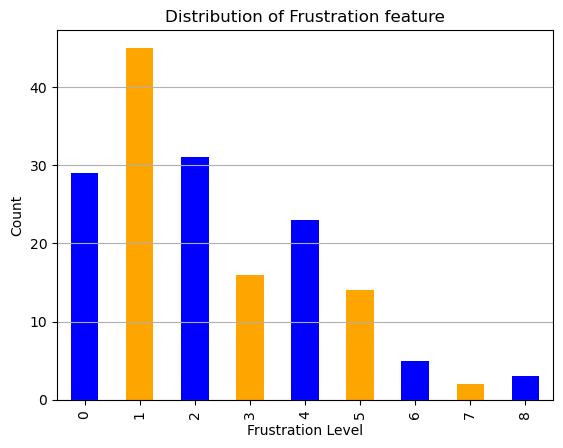

In [ ]:
print(df['Frustrated'].value_counts().sort_index())
df['Frustrated'].value_counts().sort_index().plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('Frustration Level')
plt.ylabel('Count')
plt.title('Distribution of Frustration feature')
plt.grid(axis='y')
plt.show()

In [ ]:
#defining the features and the target variable
numeric_features = ['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC']
categorical_features = ['Round', 'Phase', 'Cohort']
features = numeric_features + categorical_features

#defining X and y
X = df[features]
y = df['Frustrated']

In [ ]:
#preprocessing the features by standardizing numeric features and one-hot encoding categorical features
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

**Random Forest Classifier**

In [8]:
#creating a new binned target variable due to class imbalance
def bin_frustration(val):
    if val <= 2:
        return 0 #low frustration
    elif val <= 5:
        return 1 #medium frustration
    else:
        return 2 #high frustration
    
#apply binning function
y_binned = df['Frustrated'].apply(bin_frustration)

print("Binned Frustration Levels given in %:\n")
print((y_binned.value_counts().sort_index()/168)*100)

Binned Frustration Levels given in %:

Frustrated
0    62.500000
1    31.547619
2     5.952381
Name: count, dtype: float64


In [ ]:
#two level cross-validation to optimize the hyperparameters of the Random Forest model
outer_cv = GroupKFold(n_splits=5)

inner_cv = GroupKFold(n_splits=3)

groups = df['Individual']

#defining the parameter grid
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],    
}

#defining the pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

#nested cross-validation
nested_scores = []
outer_fold = 0
all_y_true = []
all_y_pred = []

for train_idx, test_idx in outer_cv.split(X, y_binned, groups=groups):
    outer_fold += 1
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_binned.iloc[train_idx], y_binned.iloc[test_idx]
    group_train = groups.iloc[train_idx]

    #inner CV for hyperparameter tuning
    grid_search = GridSearchCV(pipeline_rf, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train, groups=group_train)
    
    #best model from grid search
    best_model = grid_search.best_estimator_
    y_pred_rf = best_model.predict(X_test)

    #storing the results
    nested_scores.append(grid_search.best_score_)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred_rf)

#final results
print("Nested CV - Average inner macro F1 scores per fold:", nested_scores)
print("Nested CV - Mean F1 macro:", np.mean(nested_scores))

#classification report on outer predictions
print("\nFinal Evaluation on Outer Predictions:\n")
print(classification_report(all_y_true, all_y_pred, zero_division=0))

Nested CV - Average inner macro F1 scores per fold: [np.float64(0.5972222222222222), np.float64(0.7060185185185185), np.float64(0.6273148148148149), np.float64(0.6203703703703703), np.float64(0.6111111111111112)]
Nested CV - Mean F1 macro: 0.6324074074074074

Final Evaluation on Outer Predictions:

              precision    recall  f1-score   support

           0       0.75      0.86      0.80       105
           1       0.58      0.49      0.53        53
           2       0.00      0.00      0.00        10

    accuracy                           0.69       168
   macro avg       0.44      0.45      0.44       168
weighted avg       0.65      0.69      0.67       168



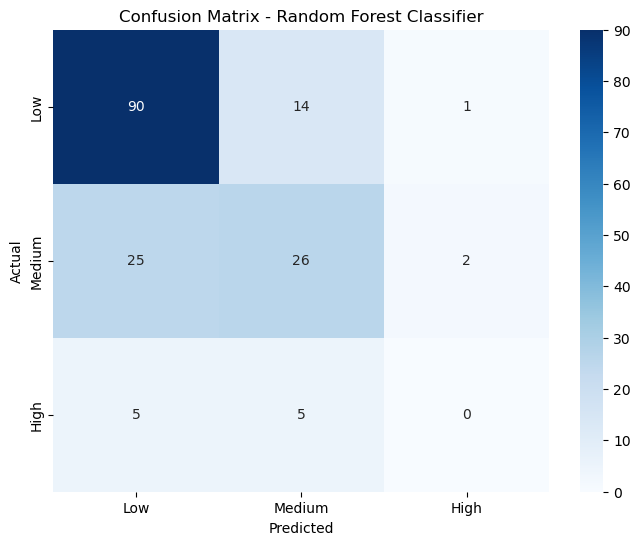

In [ ]:
#confusion matrix RF
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**KNearest Classifier**

In [11]:
#defining parameter grid for KNN
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance']
}

#defining the KNN pipeline
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

#storing results
nested_scores_knn = []
all_y_true_knn = []
all_y_pred_knn = []
outer_fold = 0

#outer loop
for train_idx, test_idx in outer_cv.split(X, y_binned, groups=groups):
    outer_fold += 1
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_binned.iloc[train_idx], y_binned.iloc[test_idx]
    group_train = groups.iloc[train_idx]

    #inner loop (GridSearchCV)
    grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=inner_cv, scoring='f1_macro', n_jobs=-1)
    grid_search_knn.fit(X_train, y_train, groups=group_train)

    best_model_knn = grid_search_knn.best_estimator_
    y_pred = best_model_knn.predict(X_test)

    nested_scores_knn.append(grid_search_knn.best_score_)
    all_y_true_knn.extend(y_test)
    all_y_pred_knn.extend(y_pred)

#final results
print("Nested CV - Average Inner Macro F1 Scores per Fold (KNN):", nested_scores_knn)
print("Nested CV - Mean F1 Macro (KNN):", np.mean(nested_scores_knn))

print("\nFinal Evaluation on Outer Predictions (KNN):\n")
print(classification_report(all_y_true_knn, all_y_pred_knn, zero_division=0))


Nested CV - Average Inner Macro F1 Scores per Fold (KNN): [np.float64(0.32306080872223336), np.float64(0.42380609838360167), np.float64(0.42295745335808177), np.float64(0.38022321923119523), np.float64(0.361718901976942)]
Nested CV - Mean F1 Macro (KNN): 0.3823532963344108

Final Evaluation on Outer Predictions (KNN):

              precision    recall  f1-score   support

           0       0.71      0.76      0.73       105
           1       0.43      0.43      0.43        53
           2       0.00      0.00      0.00        10

    accuracy                           0.61       168
   macro avg       0.38      0.40      0.39       168
weighted avg       0.58      0.61      0.60       168



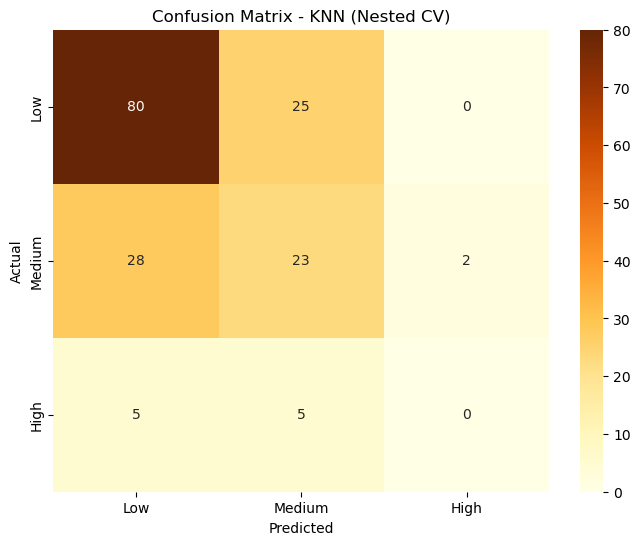

In [ ]:
#confusion Matrix KNN
cm_knn_nested = confusion_matrix(all_y_true_knn, all_y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn_nested, annot=True, fmt='d', cmap='YlOrBr',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix - KNN (Nested CV)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Model Comparison**

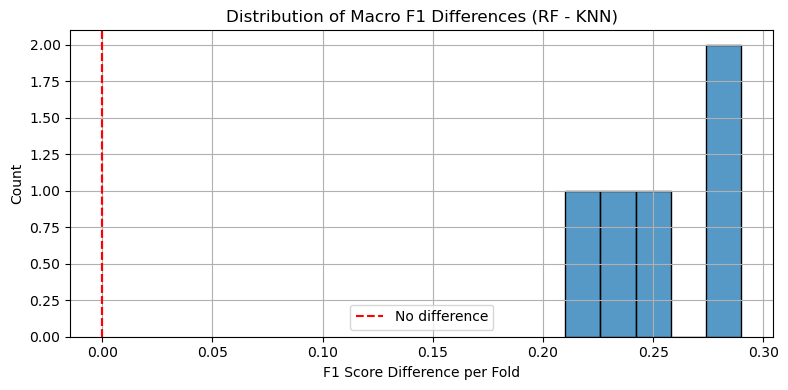

In [ ]:
rf_scores = [0.60, 0.71, 0.63, 0.62, 0.61]
knn_scores = [0.32, 0.42, 0.42, 0.38, 0.36]

#compute difference
score_diff = np.array(rf_scores) - np.array(knn_scores)

#histogram and KDE of differences
plt.figure(figsize=(8, 4))
sns.histplot(score_diff, kde=False, bins=5)
plt.axvline(0, color='red', linestyle='--', label='No difference')
plt.legend()
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Macro F1 Differences (RF - KNN)")
plt.xlabel("F1 Score Difference per Fold")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
rf_scores = nested_scores
knn_scores = nested_scores_knn

#Wilcoxon signed-rank test
stat, p_value = wilcoxon(rf_scores, knn_scores)

print(f"Wilcoxon test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value < 0.05:
    print("The difference between the models is statistically significant (p < 0.05).")
else:
    print("The difference between the models is not statistically significant (p >= 0.05).")

Wilcoxon test statistic: 0.0
P-value: 0.0625
The difference between the models is not statistically significant (p >= 0.05).
